In [ ]:
from src.segnet_model import SegNet
from src.dataset import SegmentationDataset 

import torch
import torchvision.transforms as transforms
import torch.optim as optim

from PIL import Image
# import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

In [2]:
dataset_root_path = 'data/idd20k_lite_prepared'

data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_dataset = SegmentationDataset(dataset_root_path, transform=data_transforms, mode='train')
val_dataset = SegmentationDataset(dataset_root_path, transform=data_transforms, mode='val')

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=10, shuffle=False)

# DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DEVICE = torch.device('cpu')

In [3]:
model = SegNet(in_channels=3, num_classes=34).to(DEVICE)
criterion = torch.nn.CrossEntropyLoss(ignore_index=255)  # Ignore index 255 for void class
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for images, masks in tqdm(dataloader, desc="Training", leave=False):
        images = images.to(device)                # shape: [B, 3, H, W]
        masks = masks.to(device).long()           # shape: [B, H, W], values: [0, ..., 33]

        optimizer.zero_grad()
        outputs = model(images)                   # shape: [B, 34, H, W]
        loss = criterion(outputs, masks)          # CrossEntropyLoss expects this

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Validation", leave=False):
            images = images.to(device)
            masks = masks.to(device).long()

            outputs = model(images)
            loss = criterion(outputs, masks)

            running_loss += loss.item()

    return running_loss / len(dataloader)

# Training Loop
NUM_EPOCHS = 5

for epoch in range(NUM_EPOCHS):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
    val_loss = evaluate(model, val_loader, criterion, DEVICE)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

Epoch 1/5 | Train Loss: 1.4741 | Val Loss: 0.8265


Epoch 2/5 | Train Loss: 0.7015 | Val Loss: 0.6909


Epoch 3/5 | Train Loss: 0.6191 | Val Loss: 0.6111


Epoch 4/5 | Train Loss: 0.5627 | Val Loss: 0.6096


Epoch 5/5 | Train Loss: 0.5296 | Val Loss: 0.5546


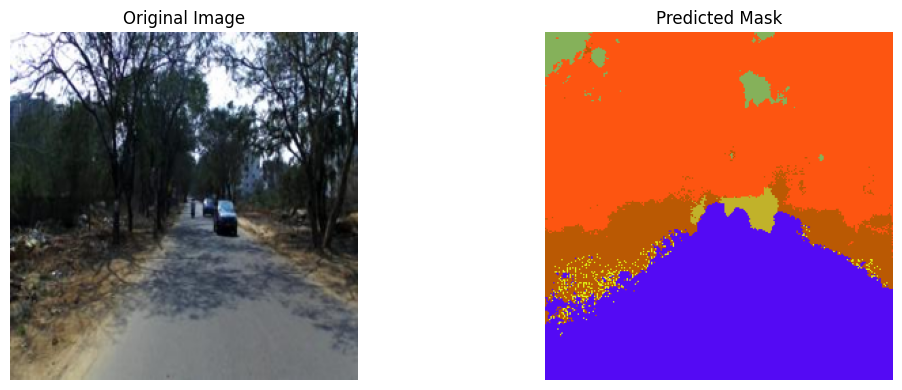

In [7]:
img_path = '/teamspace/studios/this_studio/IIITH_assignment/data/idd20k_lite_prepared/images/test/frame76567_image.jpg'
original_image = Image.open(img_path).convert('RGB')
input_tensor = data_transforms(original_image).unsqueeze(0).to(DEVICE)

# Forward pass
with torch.no_grad():
    output = model(input_tensor)  # [1, 34, 256, 256]
    pred_mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()  # [256, 256], values in 0–33

# Color palette for 34 classes (randomly assigned here; ideally use IDD palette)
colors = np.random.randint(0, 255, (34, 3), dtype=np.uint8)

# Convert segmentation mask to RGB image
seg_mask_rgb = np.zeros((256, 256, 3), dtype=np.uint8)
for cls_id in range(34):
    seg_mask_rgb[pred_mask == cls_id] = colors[cls_id]

# Convert original image to same size and array
original_image_resized = original_image.resize((256, 256))
original_np = np.array(original_image_resized)


# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_np)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Predicted Mask')
plt.imshow(seg_mask_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()